In [133]:
!pip install yfinance pandas numpy matplotlib seaborn statsmodels prophet mplfinance


In [134]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.ticker as ticker
import statsmodels.api as sm

from mplfinance.original_flavor import candlestick_ohlc
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

In [135]:
df = yf.download('^BVSP', start='2001-01-01', end='2024-06-30', progress=False)

df['Variacao'] = df['Close'].pct_change() * 100

df['Variacao'] = df['Variacao'].apply(lambda x: f"{x:+.2f}%")

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5816 entries, 2001-01-02 to 2024-06-28
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5816 non-null   float64
 1   High       5816 non-null   float64
 2   Low        5816 non-null   float64
 3   Close      5816 non-null   float64
 4   Adj Close  5816 non-null   float64
 5   Volume     5816 non-null   int64  
 6   Variacao   5816 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 363.5+ KB


In [137]:
df.reset_index(inplace=True)
df.set_index('Date', inplace=True)

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5816 entries, 2001-01-02 to 2024-06-28
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5816 non-null   float64
 1   High       5816 non-null   float64
 2   Low        5816 non-null   float64
 3   Close      5816 non-null   float64
 4   Adj Close  5816 non-null   float64
 5   Volume     5816 non-null   int64  
 6   Variacao   5816 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 363.5+ KB


In [139]:
print(df.duplicated().sum(), '- Dados dúplicados:')

0 - Dados dúplicados:


In [140]:
print("Dados nulos por coluna:")
print(df.isnull().sum())

Dados nulos por coluna:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Variacao     0
dtype: int64


In [141]:
print(f'Porcentagem de valores zerados na coluna volume: {round((df.Volume == 0).sum() / len(df) * 100, 2)}%')

Porcentagem de valores zerados na coluna volume: 25.24%


In [142]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Variacao
Date,,,,,,,
2024-06-24,121343.0,122840.0,121307.0,122637.0,122637.0,7836100,+1.07%
2024-06-25,122804.0,122849.0,121997.0,122331.0,122331.0,6942900,-0.25%
2024-06-26,122331.0,122701.0,121402.0,122641.0,122641.0,8178800,+0.25%
2024-06-27,122642.0,124308.0,122642.0,124308.0,124308.0,8707300,+1.36%
2024-06-28,124308.0,124500.0,123298.0,123907.0,123907.0,9070800,-0.32%


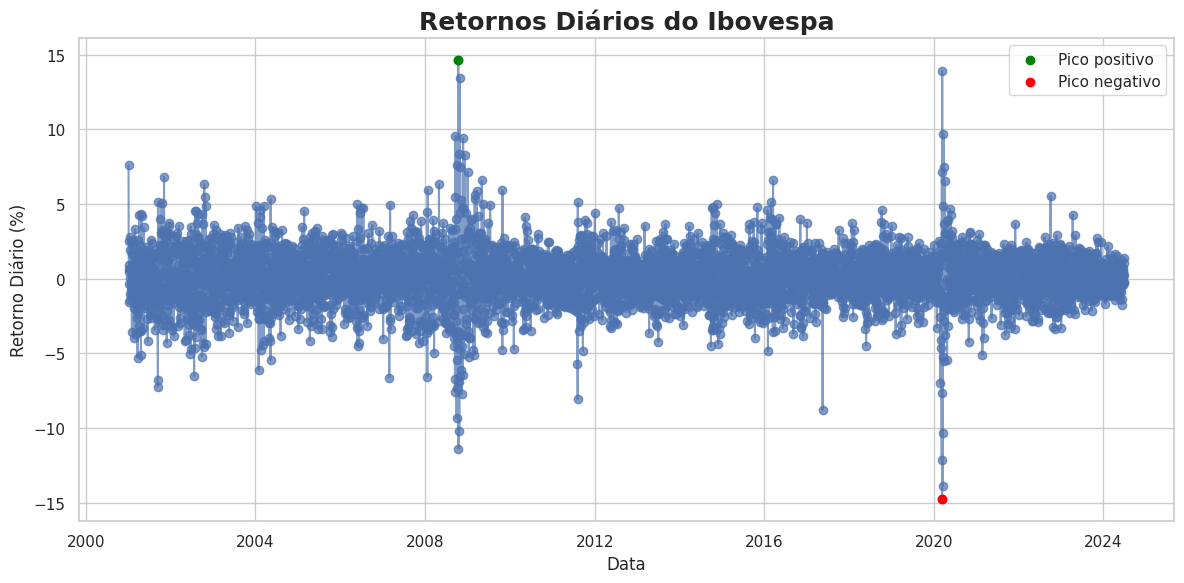

In [153]:
df['Retorno Diário'] = df['Close'].pct_change() * 100

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Retorno Diário'], marker='o', linestyle='-', color='b', alpha=0.7)

plt.scatter(df.index[df['Retorno Diário'] == df['Retorno Diário'].max()],
            df['Retorno Diário'].max(),
            color='green', label='Pico positivo', zorder=5)
plt.scatter(df.index[df['Retorno Diário'] == df['Retorno Diário'].min()],
            df['Retorno Diário'].min(),
            color='red', label='Pico negativo', zorder=5)

plt.title('Retornos Diários do Ibovespa', fontsize=18, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Retorno Diário (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [144]:
volatilidade = df['Retorno Diário'].std() * np.sqrt(252)

print(f"Volatilidade histórica anualizada: {volatilidade:.2%}")

Volatilidade histórica anualizada: 2732.00%


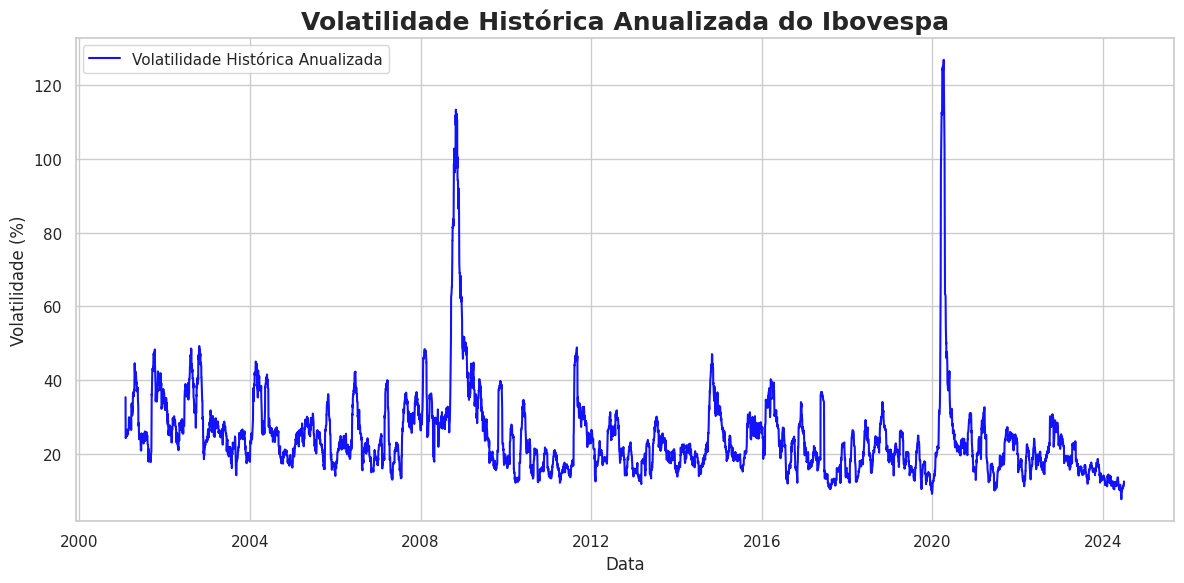

In [152]:
df['Retorno Diário'] = df['Close'].pct_change()
volatilidade = df['Retorno Diário'].std() * np.sqrt(252)  # 252 dias úteis em um ano

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Retorno Diário'].rolling(window=21).std() * np.sqrt(252) * 100,
         label='Volatilidade Histórica Anualizada', color='#1313fb')
plt.title('Volatilidade Histórica Anualizada do Ibovespa', fontsize=18, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Volatilidade (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

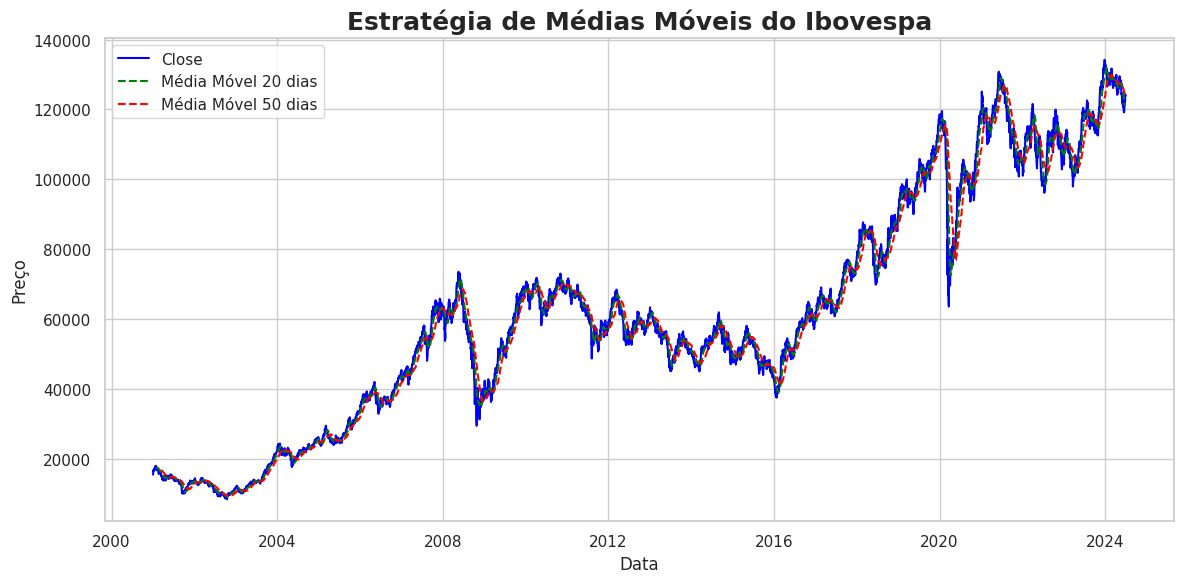

In [151]:
df.reset_index(inplace=True)
df.set_index('Date', inplace=True)

df['MM Curto'] = df['Close'].rolling(window=20).mean()
df['MM Longo'] = df['Close'].rolling(window=50).mean()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close', color='blue')
plt.plot(df.index, df['MM Curto'], label='Média Móvel 20 dias', linestyle='--', color='green')
plt.plot(df.index, df['MM Longo'], label='Média Móvel 50 dias', linestyle='--', color='red')
plt.title('Estratégia de Médias Móveis do Ibovespa', fontsize=18, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

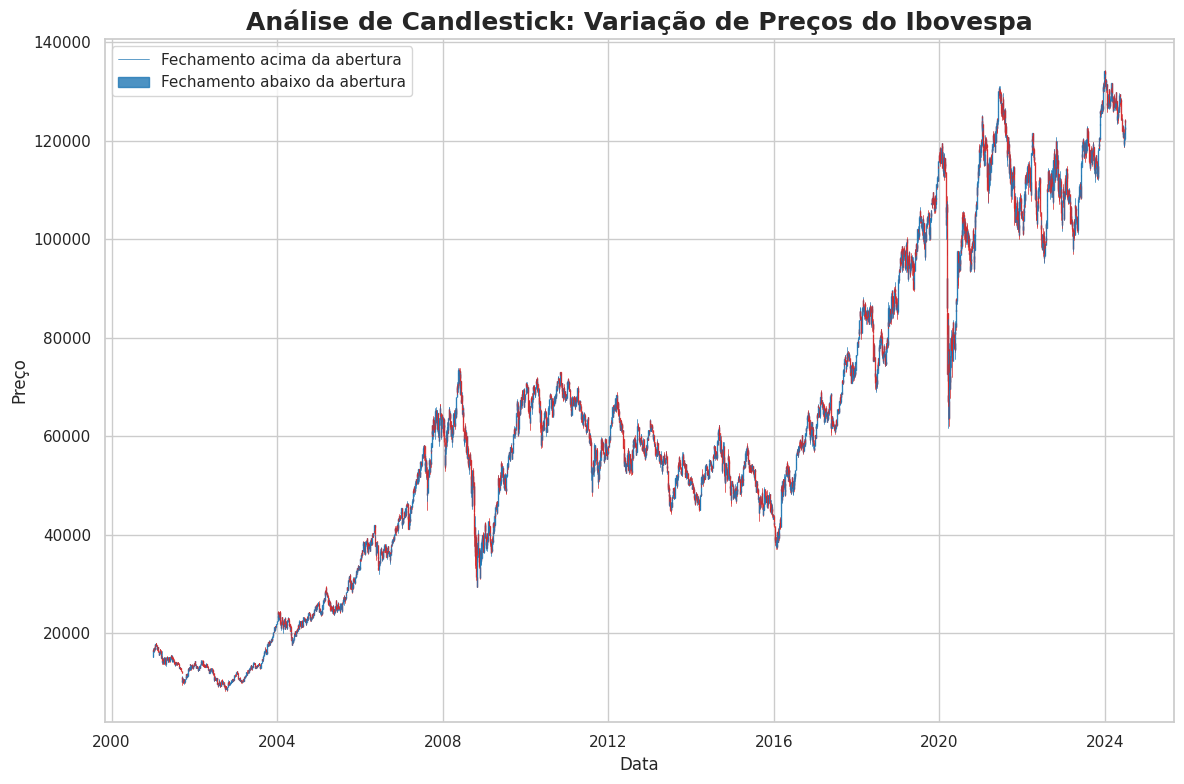

In [150]:
df.reset_index(inplace=True)
df.set_index('Date', inplace=True)

df_candle = df[['Open', 'High', 'Low', 'Close']].copy()
df_candle.reset_index(inplace=True)
df_candle['Date'] = df_candle['Date'].apply(mdates.date2num)
ohlc = df_candle[['Date', 'Open', 'High', 'Low', 'Close']].values

plt.figure(figsize=(12, 8))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='#1f77b4', colordown='#d62728', alpha=0.8)
ax.xaxis_date()

ax.grid(True)
plt.title('Análise de Candlestick: Variação de Preços do Ibovespa', fontsize=18, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Preço')

plt.legend(['Fechamento acima da abertura', 'Fechamento abaixo da abertura'], loc='upper left')

plt.tight_layout()
plt.show()

# Estatísticas | Descritivas

In [20]:
df = yf.download('^BVSP', start='2001-01-01', end='2024-06-30', progress=False)

df['Var%'] = df['Close'].pct_change() * 100

df = df.reset_index()

df = df[['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Var%']].rename(columns={
    'Date': 'Data',
    'Open': 'Abertura',
    'Close': 'Último',
    'High': 'Máxima',
    'Low': 'Mínima',
    'Volume': 'Vol.'
})

df['Data'] = pd.to_datetime(df['Data'])

df['Dia'] = df['Data'].dt.day
df['Mês'] = df['Data'].dt.month
df['Ano'] = df['Data'].dt.year

df['Data_Corrigida'] = df['Data']

df = df.rename(columns={

    'Vol.': 'Volume (M)',
    'Var%': 'Variação (%)'
})

df['Volume (M)'] = df['Volume (M)'].astype(str).apply(lambda x: float(x.split('M')[0].replace(',', '.')))

df['Variação (%)'] = pd.to_numeric(df['Variação (%)'].astype(str).apply(lambda x: x.split('%')[0].replace(',', '.')), errors='coerce')

df.drop(columns=['Data'], inplace=True)

print(df.head())
print(df.info())


    Último  Abertura   Máxima   Mínima  Volume (M)  Variação (%)  Dia  Mês  \
0  15425.0   15242.0  15621.0  15174.0         0.0           NaN    2    1   
1  16599.0   15425.0  16599.0  15251.0         0.0      7.611021    3    1   
2  16675.0   16597.0  16933.0  16587.0         0.0      0.457859    4    1   
3  16410.0   16679.0  16888.0  16380.0         0.0     -1.589205    5    1   
4  16562.0   16398.0  16623.0  16226.0         0.0      0.926264    8    1   

    Ano Data_Corrigida  
0  2001     2001-01-02  
1  2001     2001-01-03  
2  2001     2001-01-04  
3  2001     2001-01-05  
4  2001     2001-01-08  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5816 entries, 0 to 5815
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Último          5816 non-null   float64       
 1   Abertura        5816 non-null   float64       
 2   Máxima          5816 non-null   float64       
 3   Mínima   

In [21]:
dados = df

In [22]:
# Convertendo 'Volume (M)' para milhões (M) e formatando com duas casas decimais
dados['Volume (M)'] = dados['Volume (M)'] / 1_000_000  # Convertendo para milhões
dados['Volume (M)'] = dados['Volume (M)'].round(2)    # Arredondando para duas casas decimais

dados['Variação (%)'] = dados['Variação (%)'] / 1_000_000  # Convertendo para milhões
dados['Variação (%)'] = dados['Variação (%)'].round(2)    # Arredondando para duas casas decimais

In [23]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5816 entries, 0 to 5815
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Último          5816 non-null   float64       
 1   Abertura        5816 non-null   float64       
 2   Máxima          5816 non-null   float64       
 3   Mínima          5816 non-null   float64       
 4   Volume (M)      5816 non-null   float64       
 5   Variação (%)    5815 non-null   float64       
 6   Dia             5816 non-null   int32         
 7   Mês             5816 non-null   int32         
 8   Ano             5816 non-null   int32         
 9   Data_Corrigida  5816 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int32(3)
memory usage: 386.3 KB


In [24]:
dados[['Último', 'Abertura', 'Máxima', 'Mínima', 'Volume (M)', 'Variação (%)']].describe()

,Último,Abertura,Máxima,Mínima,Volume (M),Variação (%)
count,5816.000000,5816.000000,5816.000000,5816.000000,5816.000000,5815.0
mean,61259.634801,61242.645805,61848.066197,60643.338033,8.163267,0.0
std,32867.561695,32863.049161,33096.660918,32626.536861,22.437706,0.0
min,8371.000000,8397.000000,8513.000000,8225.000000,0.000000,-0.0
25%,38254.250000,38253.250000,38775.000000,37692.500000,0.000000,0.0
50%,57347.500000,57349.000000,57923.500000,56832.500000,3.050000,0.0
75%,81826.500000,81711.250000,83399.250000,80875.500000,5.950000,-0.0
max,134194.000000,134194.000000,134392.000000,133832.000000,232.270000,-0.0


In [25]:
colunas = dados[['Último', 'Abertura', 'Máxima', 'Mínima', 'Volume (M)', 'Variação (%)']].columns

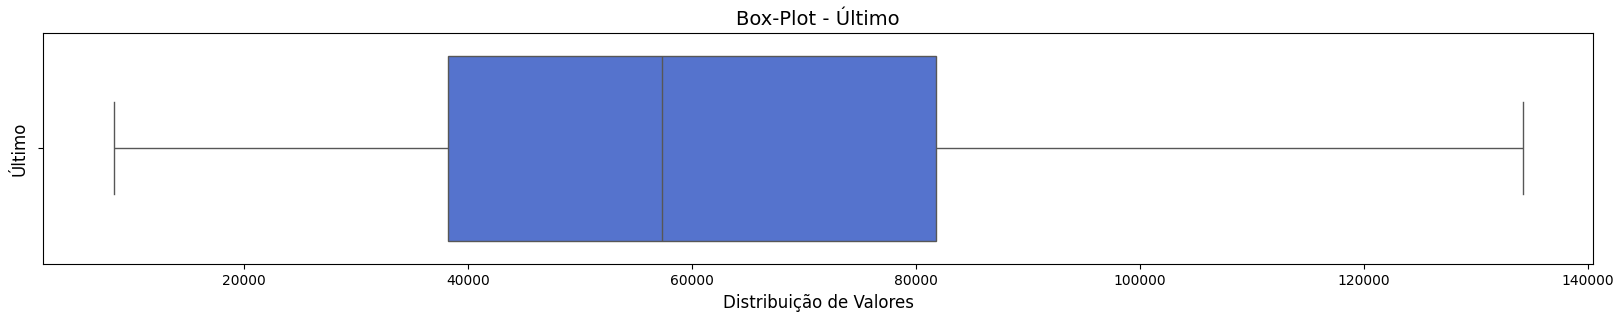

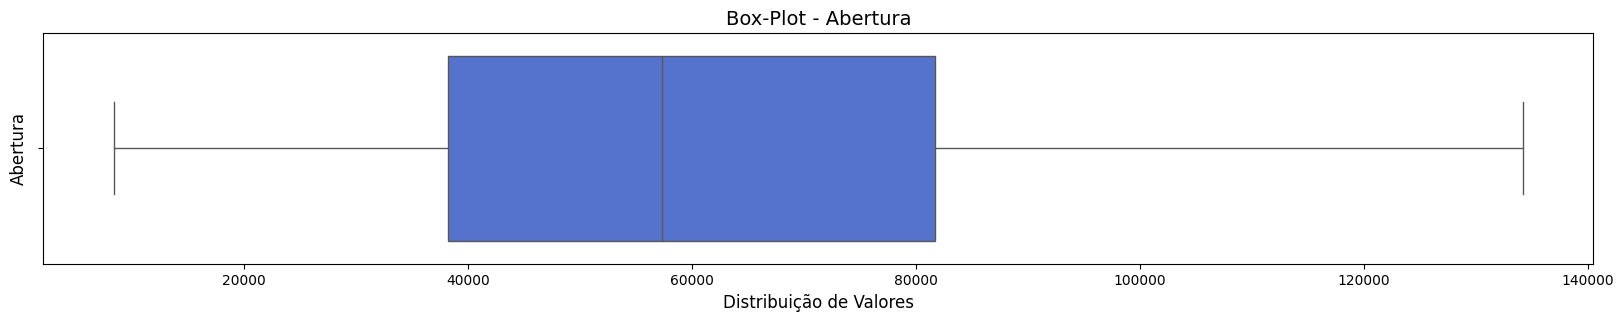

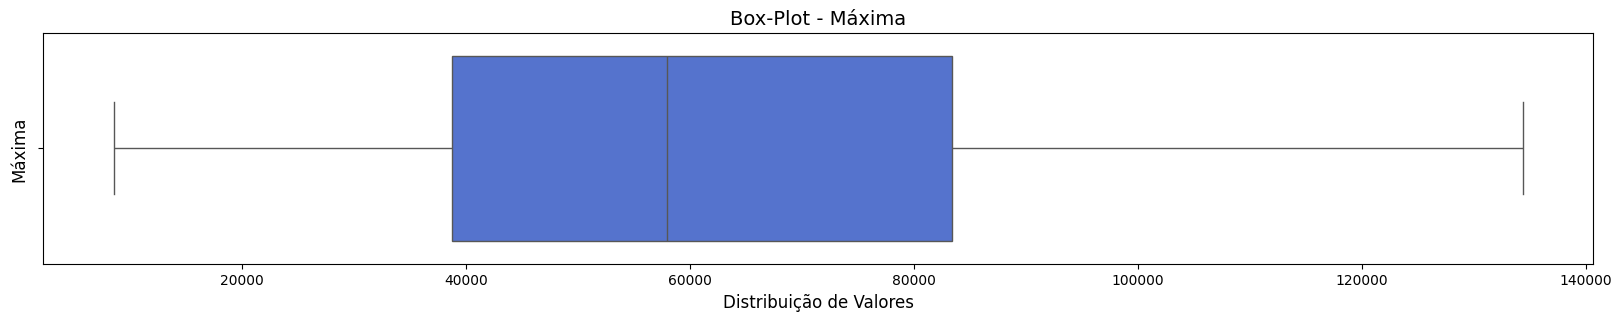

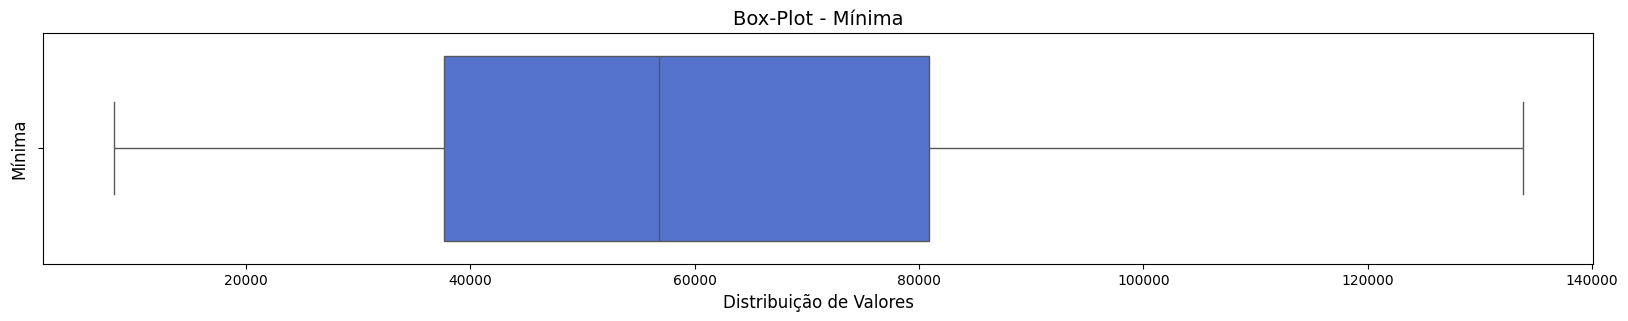

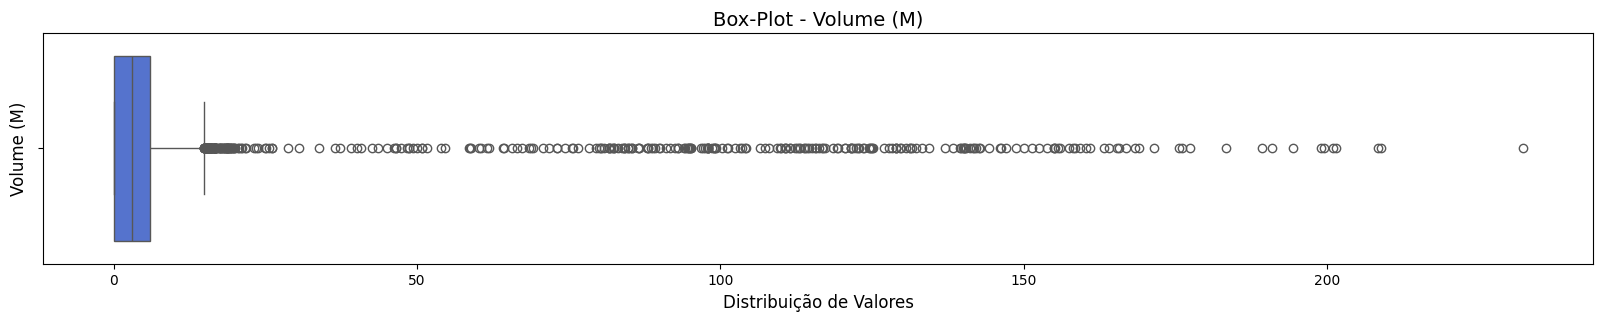

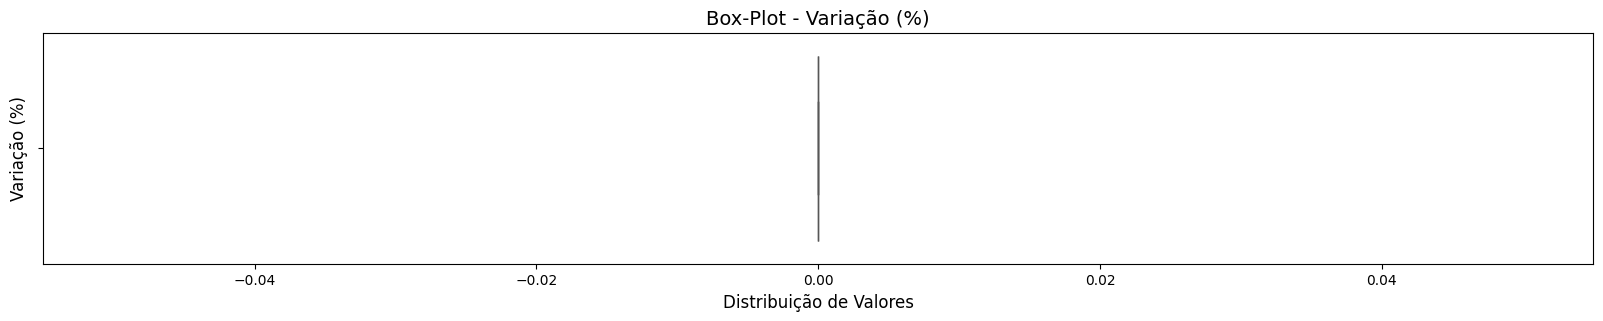

In [26]:
for col in colunas:
    plt.figure(figsize=(20, 3))
    ax = sns.boxplot(data=dados[col], orient='h', color='royalblue')
    ax.set_title(f'Box-Plot - {col}', fontsize=14)
    ax.set_xlabel('Distribuição de Valores', fontsize=12)
    ax.set_ylabel(col, fontsize=12)
    plt.show()

In [27]:
meses_traducao = {
    'Jan': 'Jan',
    'Feb': 'Fev',
    'Mar': 'Mar',
    'Apr': 'Abr',
    'May': 'Mai',
    'Jun': 'Jun',
    'Jul': 'Jul',
    'Aug': 'Ago',
    'Sep': 'Set',
    'Oct': 'Out',
    'Nov': 'Nov',
    'Dec': 'Dez'
}

In [28]:
# Máximos Mensais
maximo_mensal = dados.groupby(['Mês', 'Ano'])[['Máxima']].max().reset_index()
maximo_mensal['chave'] = maximo_mensal['Mês'].astype(str) + maximo_mensal['Ano'].astype(str)

# Fechamento
ultimo_dia = dados.groupby(['Mês', 'Ano'])[['Data_Corrigida']].max().reset_index()
ultimo_dia['chave'] = ultimo_dia['Mês'].astype(str) + ultimo_dia['Ano'].astype(str)
ultimo_dia = pd.merge(ultimo_dia, dados[['Último', 'Data_Corrigida']], on='Data_Corrigida')

# Mínimos Mensais
minimo_mensal = dados.groupby(['Mês', 'Ano'])[['Mínima']].min().reset_index()
minimo_mensal['chave'] = minimo_mensal['Mês'].astype(str) + minimo_mensal['Ano'].astype(str)

# Abertura
primeiro_dia = dados.groupby(['Mês', 'Ano'])[['Data_Corrigida']].min().reset_index()
primeiro_dia['chave'] = primeiro_dia['Mês'].astype(str) + primeiro_dia['Ano'].astype(str)
primeiro_dia = pd.merge(primeiro_dia, dados[['Abertura', 'Data_Corrigida']], on='Data_Corrigida')


# Mensais de Volume
volume_mensal = dados.groupby(['Mês', 'Ano'])[['Volume (M)']].sum().reset_index()
volume_mensal['chave'] = volume_mensal['Mês'].astype(str) + volume_mensal['Ano'].astype(str)

# Merge dos Dados
merge_1 = pd.merge(ultimo_dia[['Último', 'chave']], primeiro_dia[['Abertura', 'chave']], on='chave')
merge_2 = pd.merge(maximo_mensal[['Máxima', 'chave']], minimo_mensal[['Mínima', 'chave']], on='chave')
merge_3 = pd.merge(merge_1, merge_2, on='chave')
merge_4 = pd.merge(merge_3, volume_mensal, on='chave')

# DataFrame Mensal Final
dados_mensais = merge_4
dados_mensais['Data_Base'] = pd.to_datetime(
                                            dados_mensais['Ano'].astype(str) + '-' +
                                            dados_mensais['Mês'].astype(str) + '-' +
                                            '01'
                                            )
dados_mensais['Data_Eixo'] = dados_mensais['Data_Base'].apply(lambda x: x.strftime('%b')).map(meses_traducao)
dados_mensais = merge_4.drop(columns=['chave', 'Mês', 'Ano'])
dados_mensais = dados_mensais[['Data_Base', 'Data_Eixo','Último', 'Abertura', 'Máxima', 'Mínima', 'Volume (M)']]
dados_mensais = dados_mensais.sort_values(by=['Data_Base'], ascending=True).reset_index(drop=True)
dados_mensais['Variação (%)'] = round(dados_mensais['Último'].pct_change() * 100, 2)
dados_mensais.head()

,Data_Base,Data_Eixo,Último,Abertura,Máxima,Mínima,Volume (M),Variação (%)
0,2001-01-01,Jan,17673.0,15242.0,18023.0,15174.0,0.0,NaN
1,2001-02-01,Fev,15891.0,17670.0,17673.0,15558.0,0.0,-10.08
2,2001-03-01,Mar,14438.0,15891.0,16813.0,13761.0,0.0,-9.14
3,2001-04-01,Abr,14918.0,14441.0,15267.0,13325.0,0.0,3.32
4,2001-05-01,Mai,14650.0,14877.0,15304.0,14056.0,0.0,-1.80


In [29]:
anos = dados_mensais['Data_Base'].dt.year.unique()

<ipython-input-128-1ef6356723c9>:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=dados_anuais, x='Ano', y='Variação (%)', palette=palette, ci=None)
<ipython-input-128-1ef6356723c9>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=dados_anuais, x='Ano', y='Variação (%)', palette=palette, ci=None)
<ipython-input-128-1ef6356723c9>:13: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  ax = sns.barplot(data=dados_anuais, x='Ano', y='Variação (%)', palette=palette, ci=None)


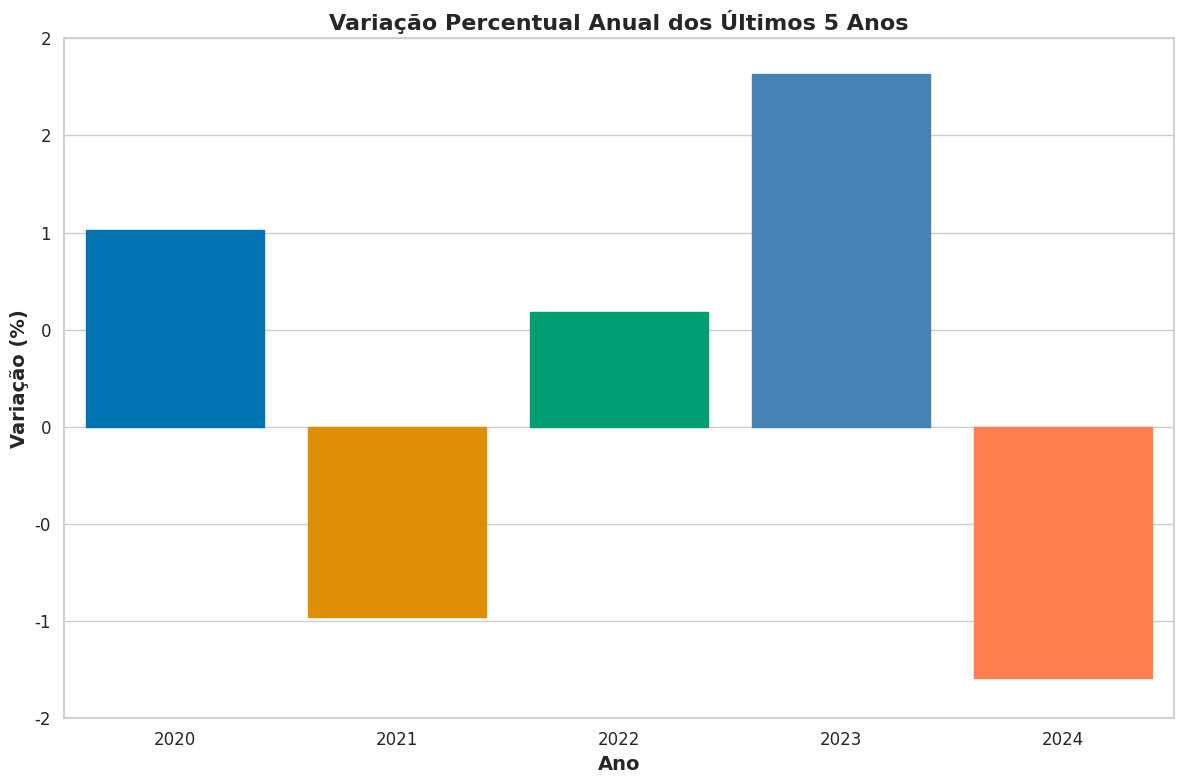

In [128]:
palette = sns.color_palette("colorblind")

anos_disponiveis = dados_mensais['Data_Base'].dt.year.unique()
ultimos_cinco_anos = sorted(anos_disponiveis)[-5:]
dados_anuais = dados_mensais[dados_mensais['Data_Base'].dt.year.isin(ultimos_cinco_anos)]
dados_anuais = dados_anuais.groupby(dados_anuais['Data_Base'].dt.year)['Variação (%)'].mean().reset_index()
dados_anuais.columns = ['Ano', 'Variação (%)']

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=dados_anuais, x='Ano', y='Variação (%)', palette=palette, ci=None)

maior_variacao = dados_anuais['Variação (%)'].max()
menor_variacao = dados_anuais['Variação (%)'].min()

for i, bar in enumerate(ax.patches):
    if bar.get_height() == maior_variacao:
        bar.set_color('steelblue')
    elif bar.get_height() == menor_variacao:
        bar.set_color('coral')
    else:
        bar.set_color(palette[i % len(palette)])

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticks(ax.get_yticks())
ax.tick_params(axis='y', labelsize=12)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))

ax.set_xlabel('Ano', fontsize=14, fontweight='bold')
ax.set_ylabel('Variação (%)', fontsize=14, fontweight='bold')
ax.set_title('Variação Percentual Anual dos Últimos 5 Anos', fontsize=16, fontweight='bold', horizontalalignment="center")

plt.tight_layout()
plt.show()

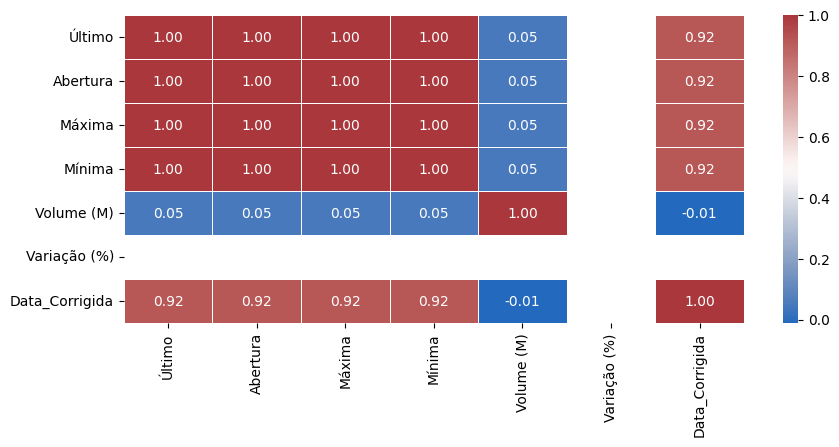

In [31]:
corr = dados.drop(columns=['Dia', 'Mês', 'Ano'], axis=1).corr()

plt.figure(figsize=(10, 4))

sns.heatmap(corr, annot=True, fmt=".2f", linewidth=.5, cmap="vlag")

plt.show()

In [32]:
dados_ts = dados[['Último', 'Data_Corrigida']].set_index('Data_Corrigida').sort_index()
dados_ts.head()

,Último
Data_Corrigida,
2001-01-02,15425.0
2001-01-03,16599.0
2001-01-04,16675.0
2001-01-05,16410.0
2001-01-08,16562.0


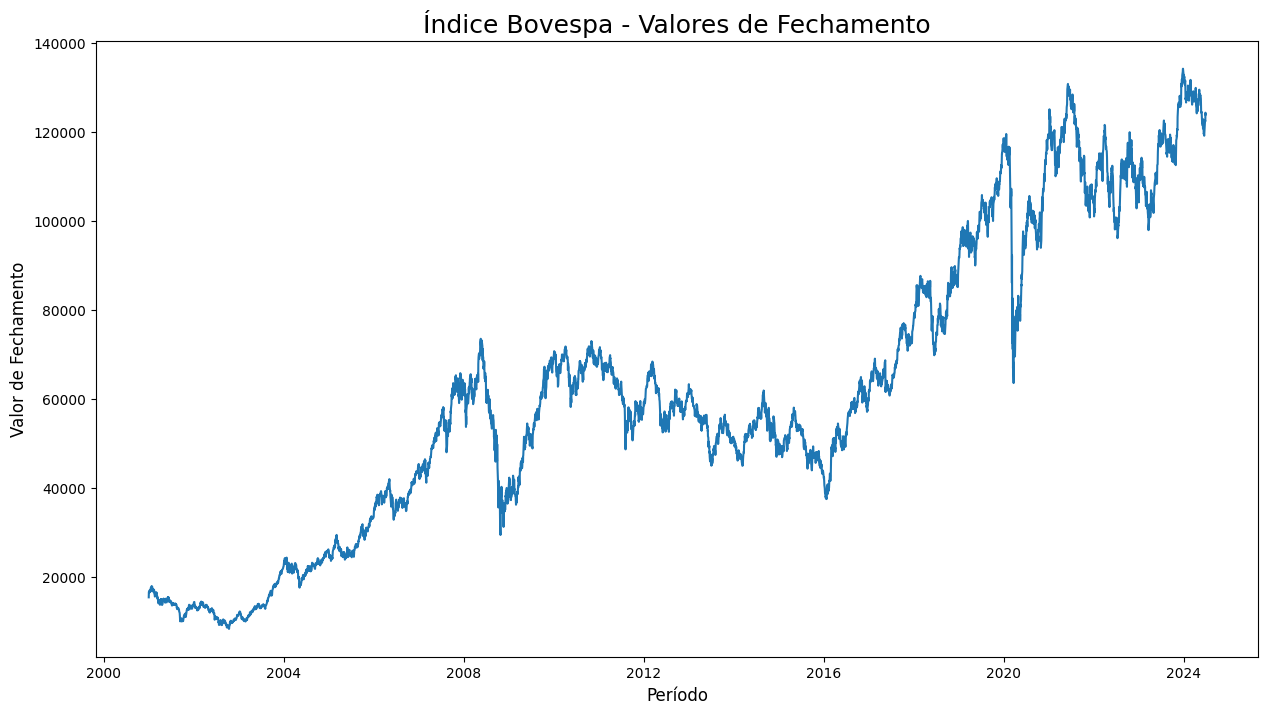

In [33]:
plt.figure(figsize = (15,8))

plt.plot(dados_ts.index, dados_ts.Último)
plt.title('Índice Bovespa - Valores de Fechamento', fontsize=18)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Valor de Fechamento', fontsize=12)

plt.show()

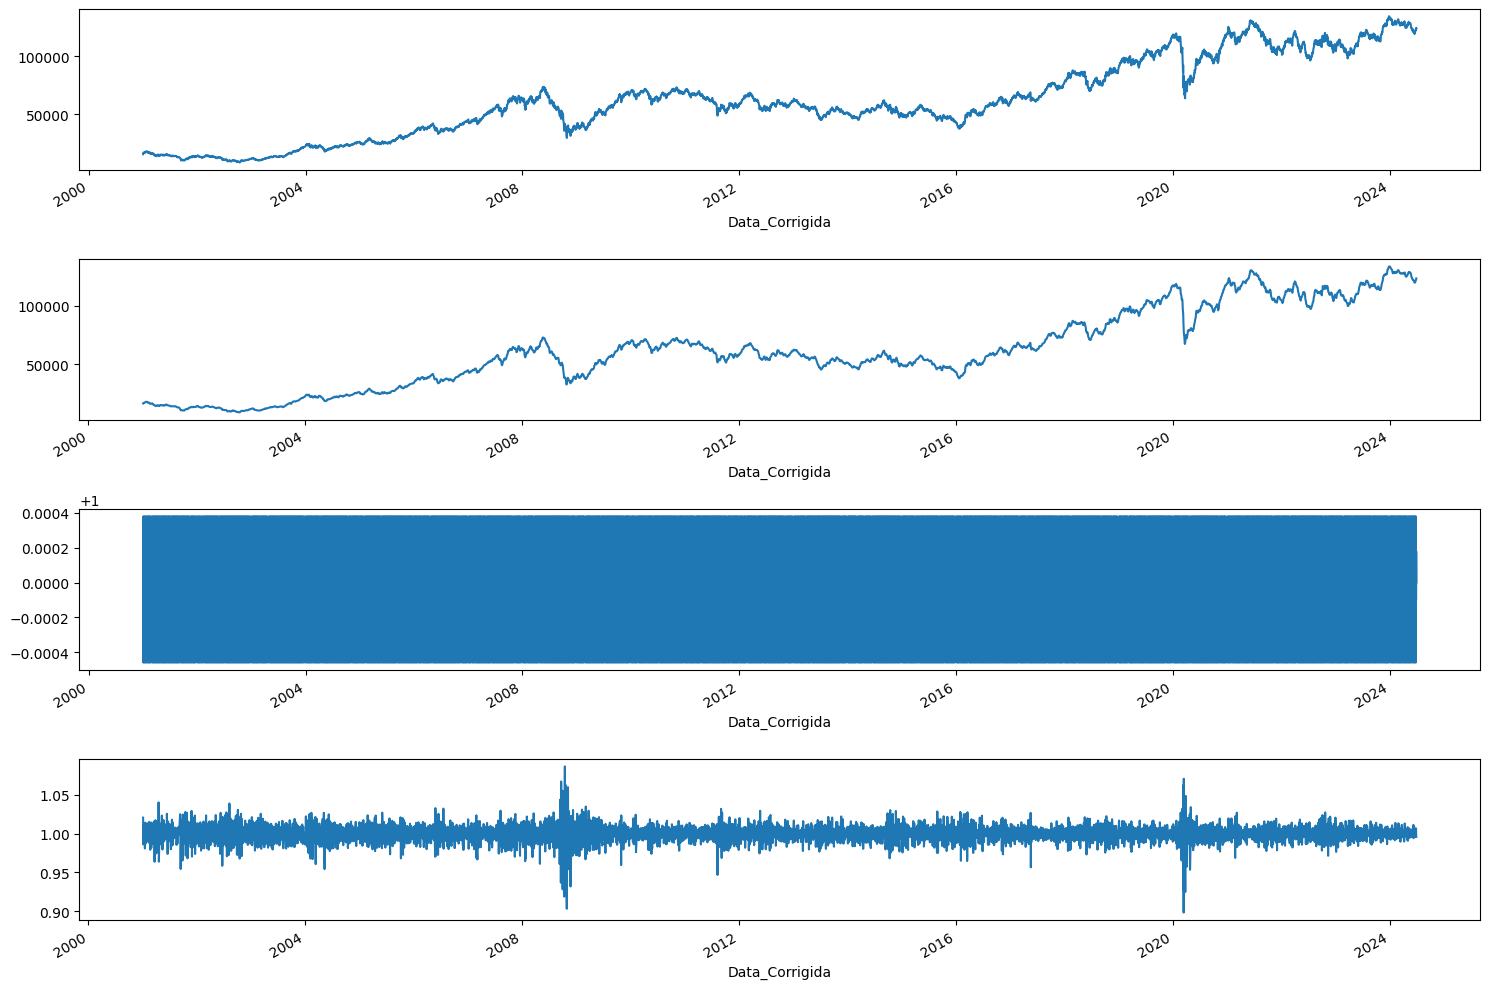

In [34]:
resultados = seasonal_decompose(dados_ts, model='multiplicative', period=5)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))

resultados.observed.plot(ax=ax1)

resultados.trend.plot(ax=ax2)

resultados.seasonal.plot(ax=ax3)

resultados.resid.plot(ax=ax4)

plt.tight_layout()

In [95]:
adf = dados_ts['Último'].values

# Teste de Dickey-Fuller Aumentado
result = adfuller(adf)

print('-----------Teste ADF Inicial-----------')
print(f'Teste Estatístico: {result[0]}')
print(f'P-Valor: {result[1]}')
print(f'Valores Críticos:')

for key, value in result[4].items():
    print(f'\t{key}: {value}')

-----------Teste ADF Inicial-----------
Teste Estatístico: -0.8851982117564196
P-Valor: 0.7928077704268026
Valores Críticos:
	1%: -3.4314771871987184
	5%: -2.8620381100423002
	10%: -2.567035141967017


In [84]:
dados_ts_media_movel = dados_ts.copy()
dados_ts_media_movel['Último_Media_Movel_15d'] = dados_ts_media_movel['Último'].rolling(15).mean().shift()
dados_ts_media_movel['Último_Media_Movel_30d'] = dados_ts_media_movel['Último'].rolling(30).mean().shift()
dados_ts_media_movel

,Último,Último_Media_Movel_15d,Último_Media_Movel_30d
Data_Corrigida,,,
2001-01-02,15425.0,NaN,NaN
2001-01-03,16599.0,NaN,NaN
2001-01-04,16675.0,NaN,NaN
2001-01-05,16410.0,NaN,NaN
2001-01-08,16562.0,NaN,NaN
...,...,...,...
2024-06-24,122637.0,120752.266667,123431.533333
2024-06-25,122331.0,120792.600000,123266.100000
2024-06-26,122641.0,120827.866667,123071.966667


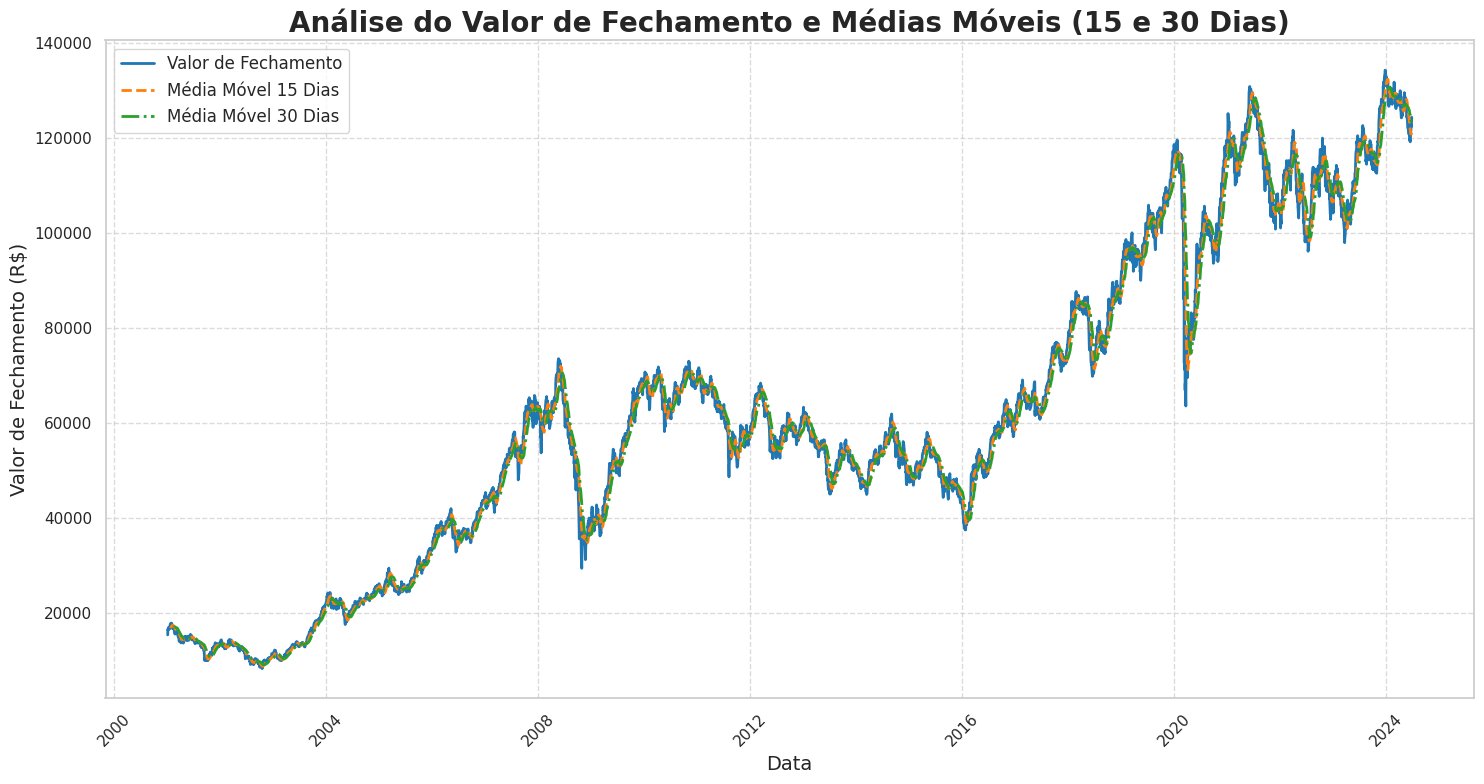

In [88]:
sns.set(style="whitegrid")

plt.figure(figsize=(15, 8))

plt.plot(dados_ts_media_movel.index, dados_ts_media_movel['Último'], color='#1f77b4', linestyle='-', linewidth=2, label='Valor de Fechamento')
plt.plot(dados_ts_media_movel.index, dados_ts_media_movel['Último_Media_Movel_15d'], color='#ff7f0e', linestyle='--', linewidth=2, label='Média Móvel 15 Dias')
plt.plot(dados_ts_media_movel.index, dados_ts_media_movel['Último_Media_Movel_30d'], color='#2ca02c', linestyle='-.', linewidth=2, label='Média Móvel 30 Dias')

plt.title('Análise do Valor de Fechamento e Médias Móveis (15 e 30 Dias)', fontsize=20, fontweight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Valor de Fechamento (R$)', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.legend(loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()

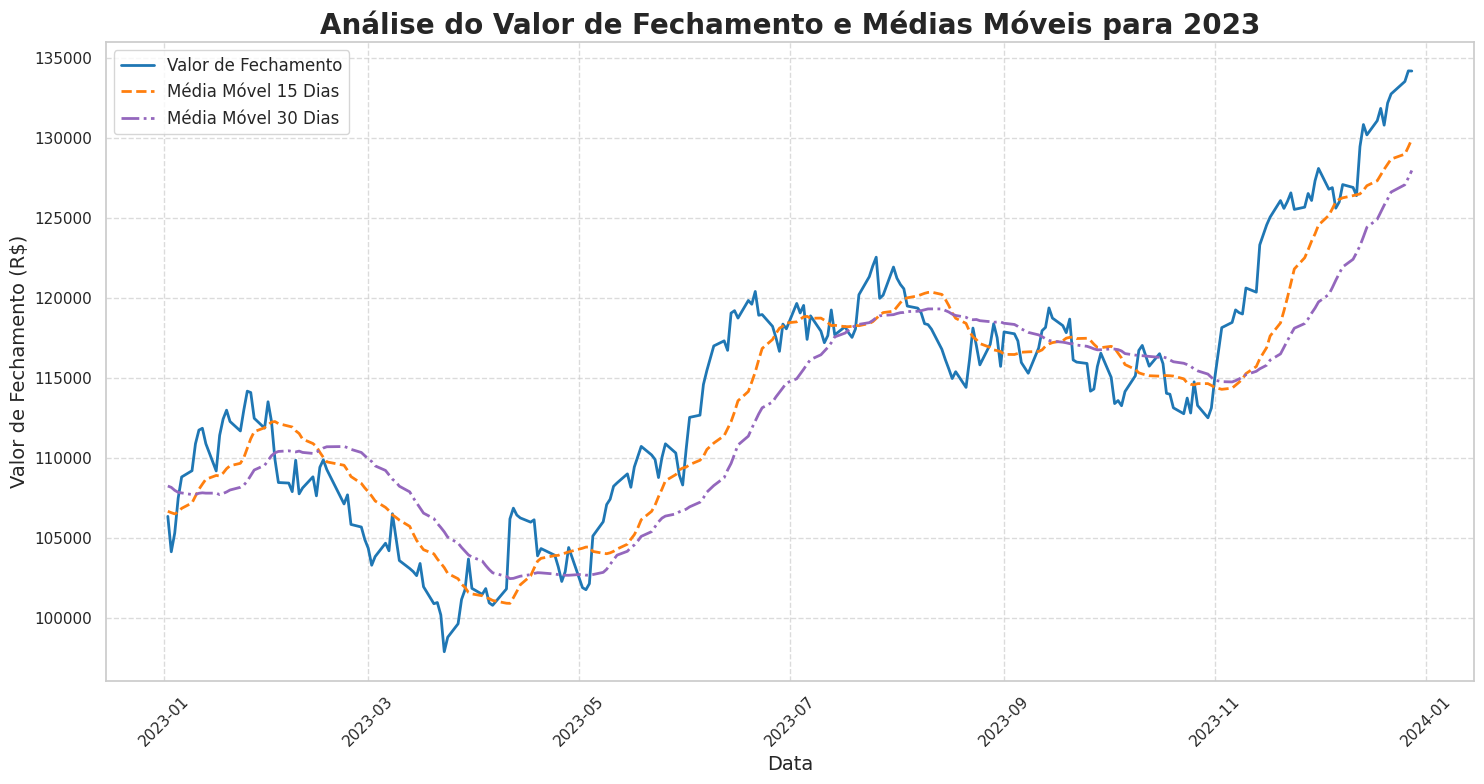

In [93]:
# Filtrar os dados para o ano de 2023
dados_2023 = dados_ts_media_movel[dados_ts_media_movel.index.to_period('Y') == '2023']

sns.set(style="whitegrid")

plt.figure(figsize=(15, 8))

plt.plot(dados_2023.index, dados_2023['Último'], color='#1f77b4', linestyle='-', linewidth=2, label='Valor de Fechamento')  # Azul
plt.plot(dados_2023.index, dados_2023['Último_Media_Movel_15d'], color='#ff7f0e', linestyle='--', linewidth=2, label='Média Móvel 15 Dias')  # Laranja
plt.plot(dados_2023.index, dados_2023['Último_Media_Movel_30d'], color='#9467bd', linestyle='-.', linewidth=2, label='Média Móvel 30 Dias')  # Roxo

plt.title('Análise do Valor de Fechamento e Médias Móveis para 2023', fontsize=20, fontweight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Valor de Fechamento (R$)', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.legend(loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()


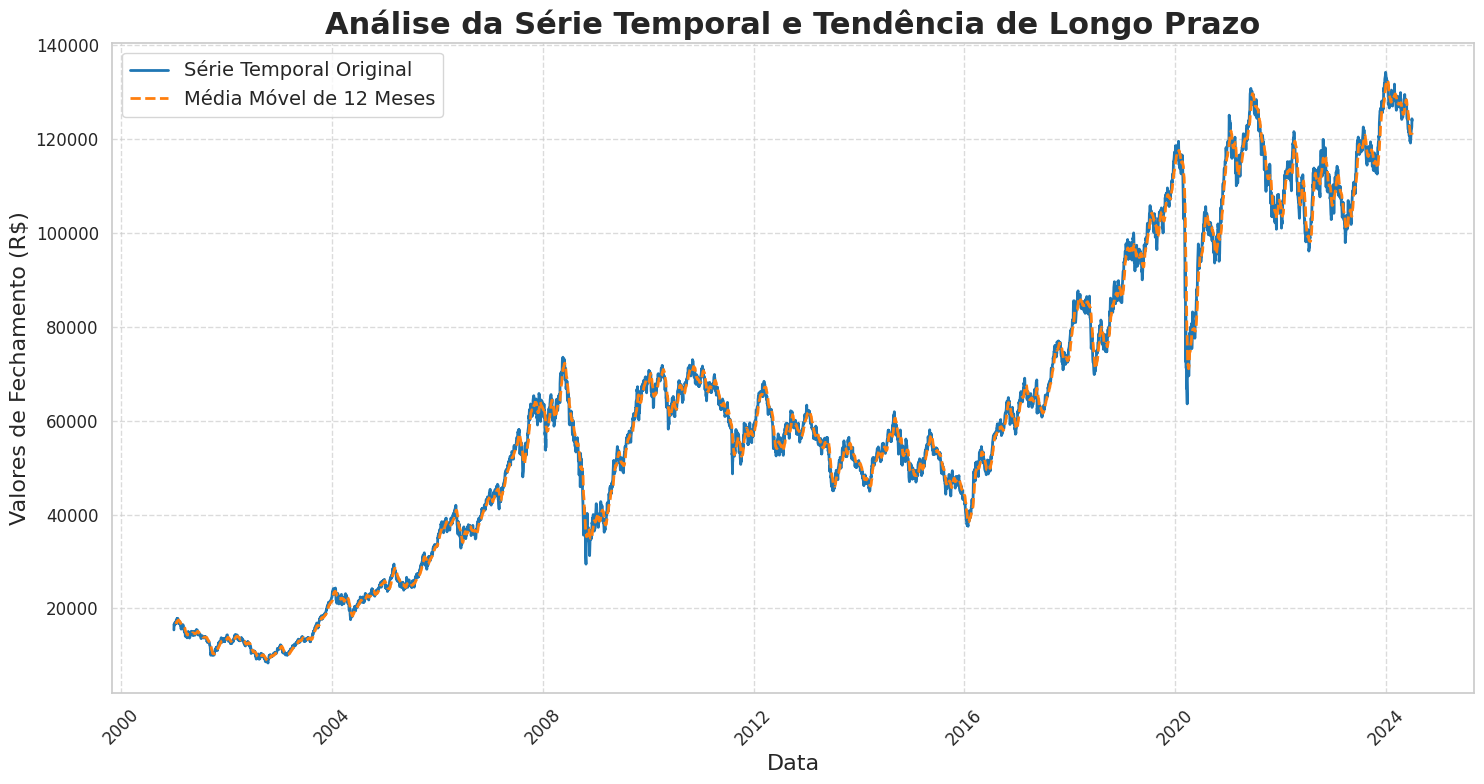

In [117]:
sns.set(style="whitegrid")

media_movel = dados_ts.rolling(12).mean()

plt.figure(figsize=(15, 8))

plt.plot(dados_ts, label='Série Temporal Original', color='#1f77b4', linestyle='-', linewidth=2)
plt.plot(media_movel, label='Média Móvel de 12 Meses', color='#ff7f0e', linestyle='--', linewidth=2)

plt.title('Análise da Série Temporal e Tendência de Longo Prazo', fontsize=22, fontweight='bold')
plt.xlabel('Data', fontsize=16)
plt.ylabel('Valores de Fechamento (R$)', fontsize=16)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc='upper left', fontsize=14)

plt.tight_layout()

plt.show()

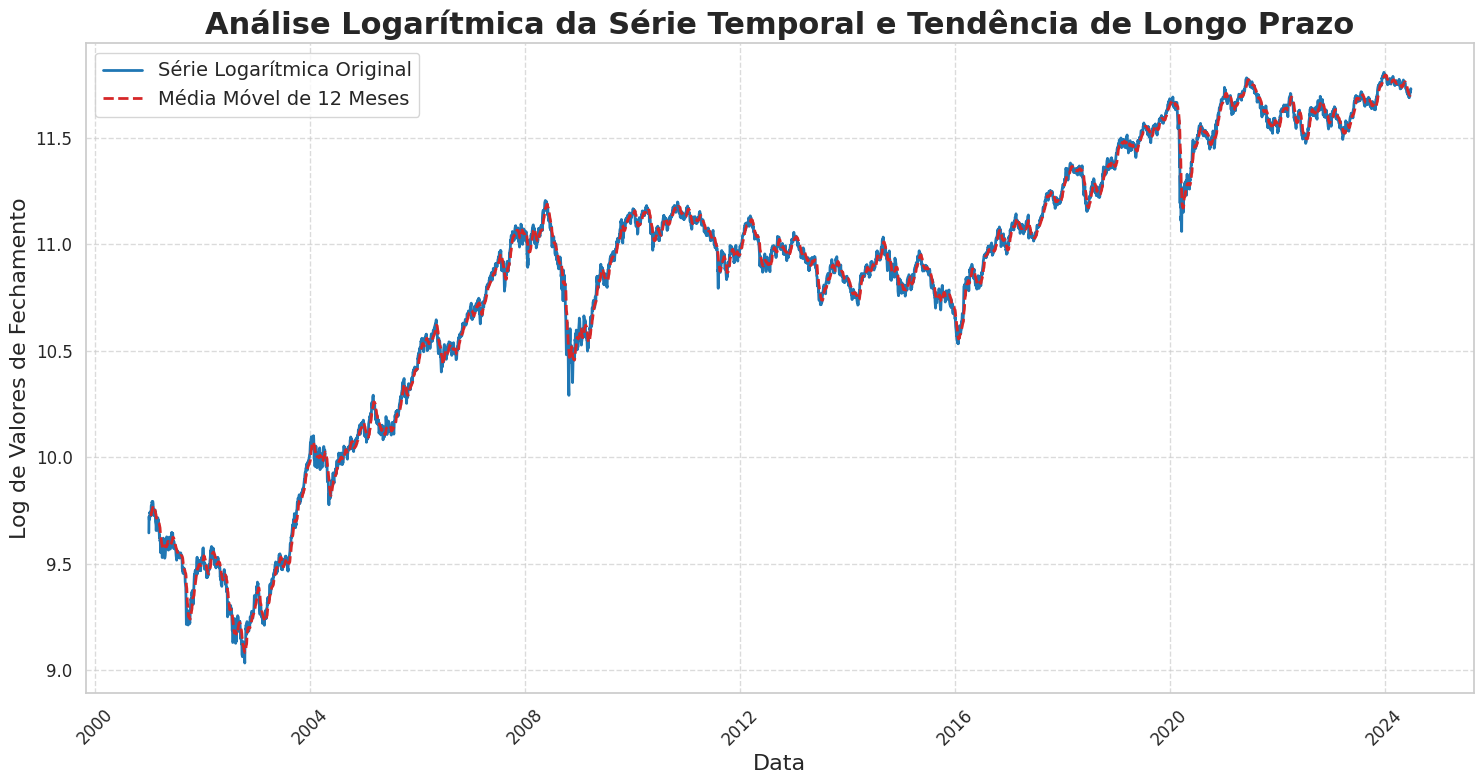

In [118]:
sns.set(style="whitegrid")

dados_ts_log = np.log(dados_ts)
ma_log = dados_ts_log.rolling(12).mean()

plt.figure(figsize=(15, 8))

plt.plot(dados_ts_log, label='Série Logarítmica Original', color='#1f77b4', linestyle='-', linewidth=2)
plt.plot(ma_log, label='Média Móvel de 12 Meses', color='#d62728', linestyle='--', linewidth=2)

plt.title('Análise Logarítmica da Série Temporal e Tendência de Longo Prazo', fontsize=22, fontweight='bold')
plt.xlabel('Data', fontsize=16)
plt.ylabel('Log de Valores de Fechamento', fontsize=16)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc='upper left', fontsize=14)

plt.tight_layout()

plt.show()

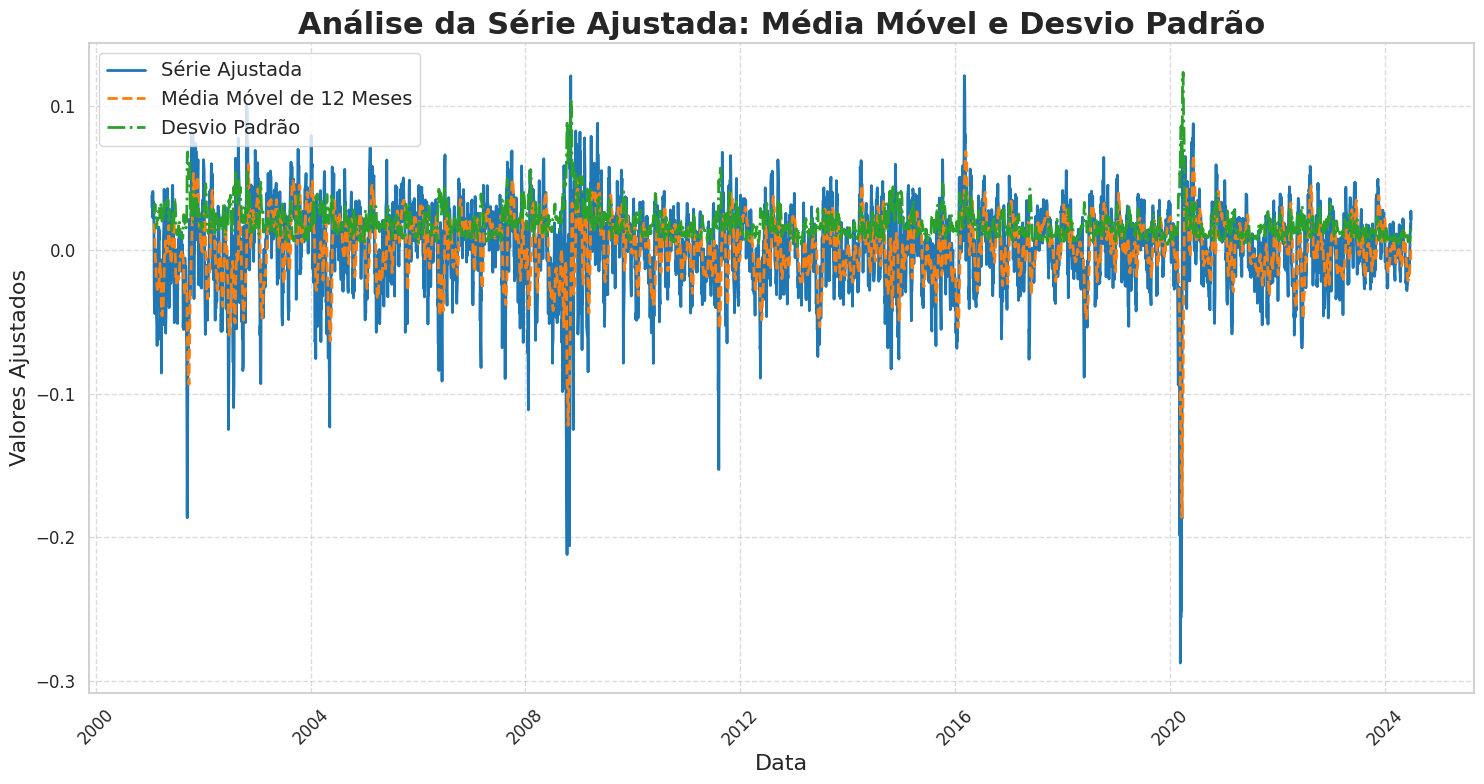

In [119]:
sns.set(style="whitegrid")

dados_ts_s = (dados_ts_log - ma_log).dropna()
ma_s = dados_ts_s.rolling(12).mean()
std_s = dados_ts_s.rolling(12).std()

plt.figure(figsize=(15, 8))

plt.plot(dados_ts_s, label='Série Ajustada', color='#1f77b4', linestyle='-', linewidth=2)
plt.plot(ma_s, label='Média Móvel de 12 Meses', color='#ff7f0e', linestyle='--', linewidth=2)
plt.plot(std_s, label='Desvio Padrão', color='#2ca02c', linestyle='-.', linewidth=2)

plt.title('Análise da Série Ajustada: Média Móvel e Desvio Padrão', fontsize=22, fontweight='bold')
plt.xlabel('Data', fontsize=16)
plt.ylabel('Valores Ajustados', fontsize=16)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc='upper left', fontsize=14)

plt.tight_layout()

plt.show()

In [101]:
# Reaplicando o Teste de Dickey-Fuller (ADF)

adf_s = dados_ts_s['Último'].values

result = adfuller(adf_s)

print('-----------Teste ADF Após Tratamento-----------')
print(f'Teste Estatístico: {result[0]}')
print(f'P-Valor: {result[1]}')
print(f'Valores Críticos:')

for key, value in result[4].items():
    print(f'\t{key}: {value}')

-----------Teste ADF Após Tratamento-----------
Teste Estatístico: -14.720229525516183
P-Valor: 2.7592920181416395e-27
Valores Críticos:
	1%: -3.4314806953877275
	5%: -2.8620396600349722
	10%: -2.5670359670726235


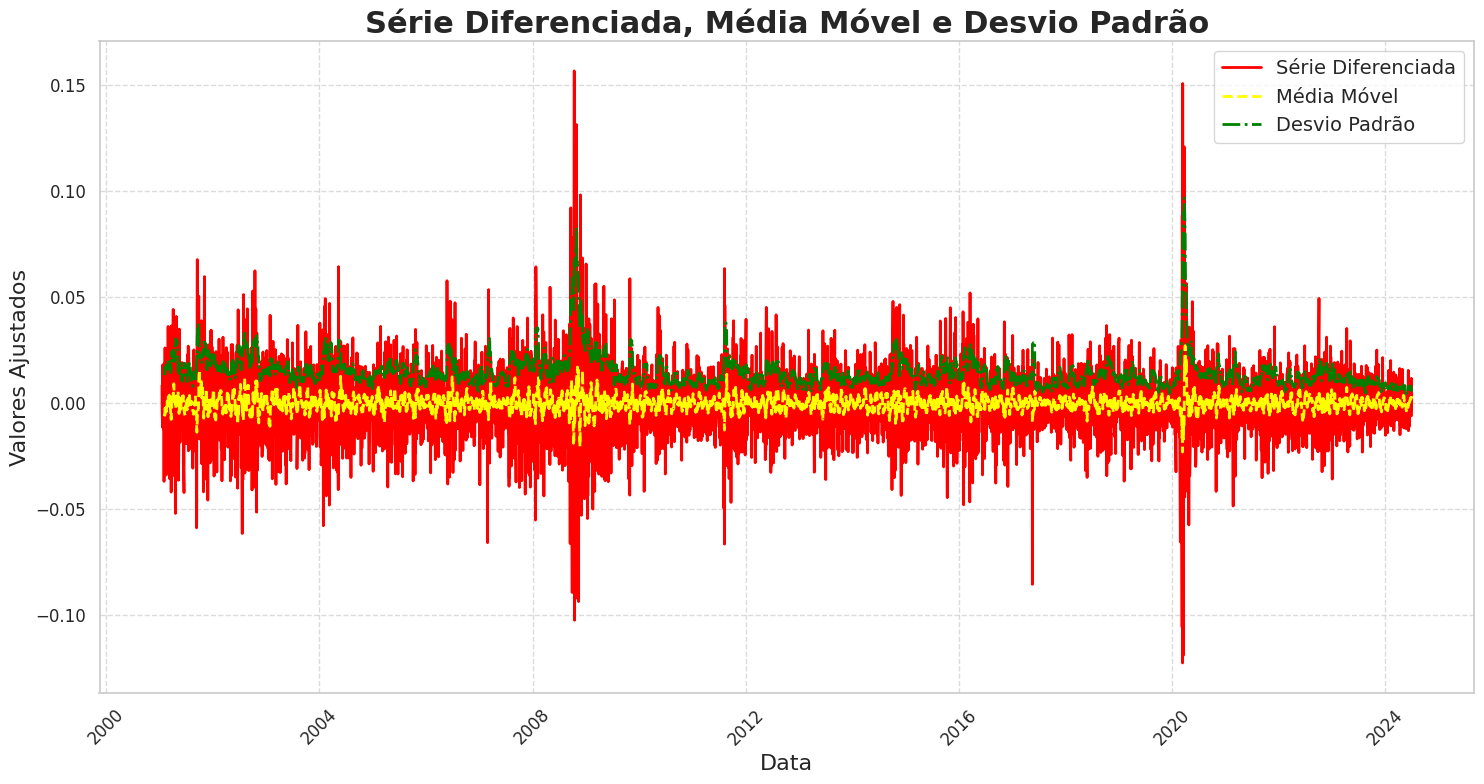

In [120]:
sns.set(style="whitegrid")

dados_ts_diff = dados_ts_s.diff().dropna()
ma_diff = dados_ts_diff.rolling(12).mean()
std_diff = dados_ts_diff.rolling(12).std()

plt.figure(figsize=(15, 8))

plt.plot(dados_ts_diff, label='Série Diferenciada', color='red', linestyle='-', linewidth=2)
plt.plot(ma_diff, label='Média Móvel', color='yellow', linestyle='--', linewidth=2)
plt.plot(std_diff, label='Desvio Padrão', color='green', linestyle='-.', linewidth=2)

plt.title('Série Diferenciada, Média Móvel e Desvio Padrão', fontsize=22, fontweight='bold')
plt.xlabel('Data', fontsize=16)
plt.ylabel('Valores Ajustados', fontsize=16)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc='best', fontsize=14)

plt.tight_layout()

plt.show()

In [103]:
# Aplicando o teste ADF para a diferenciação

adf_diff = dados_ts_diff['Último'].values

result = adfuller(adf_diff)

print('-----------Teste ADF Diferenciação-----------')
print(f'Teste Estatístico: {result[0]}')
print(f'P-Valor: {result[1]}')
print(f'Valores Críticos:')

for key, value in result[4].items():
    print(f'\t{key}: {value}')

-----------Teste ADF Diferenciação-----------
Teste Estatístico: -20.141387694190072
P-Valor: 0.0
Valores Críticos:
	1%: -3.4314838321614083
	5%: -2.86204104592689
	10%: -2.56703670482295


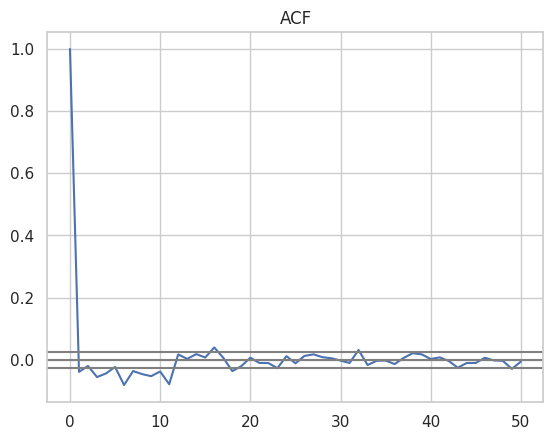

In [106]:
lag_acf = acf(dados_ts_diff.dropna(), nlags=50)

plt.plot(lag_acf)


plt.axhline(y = -1.96 / np.sqrt(len(dados_ts_diff) - 1), linestyle='-', color='gray')

plt.axhline(y = 0, linestyle='-', color='gray')


plt.axhline(y = 1.96 / np.sqrt(len(dados_ts_diff) - 1), linestyle='-', color='gray')

plt.title('ACF')
plt.show()

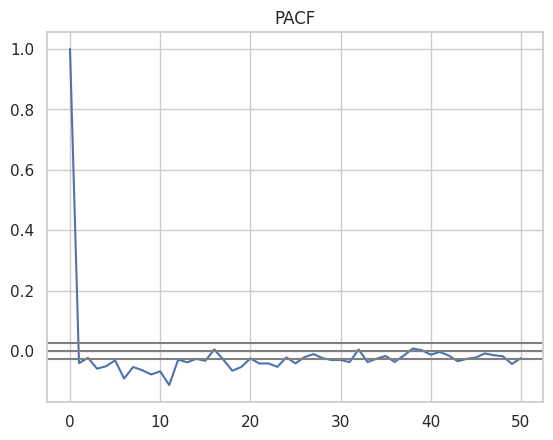

In [109]:
lag_pacf = pacf(dados_ts_diff.dropna(), nlags=50)

plt.plot(lag_pacf)

plt.axhline(y = -1.96 / np.sqrt(len(dados_ts_diff) - 1), linestyle='-', color='gray')

plt.axhline(y = 0, linestyle='-', color='gray')

plt.axhline(y = 1.96 / np.sqrt(len(dados_ts_diff) - 1), linestyle='-', color='gray')

plt.title('PACF')
plt.show()

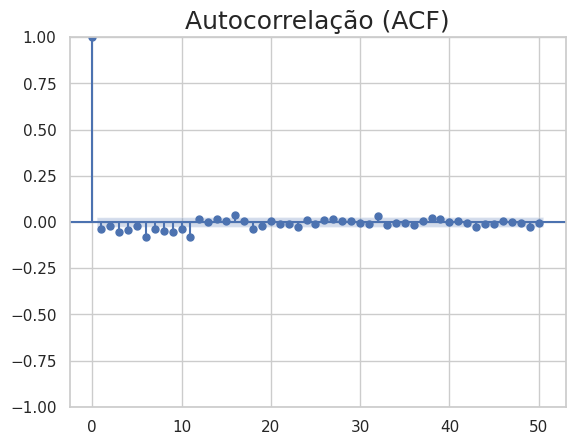

In [112]:
sm.graphics.tsa.plot_acf(dados_ts_diff, lags=50)

plt.title('Autocorrelação (ACF)', fontsize=18)

plt.show()

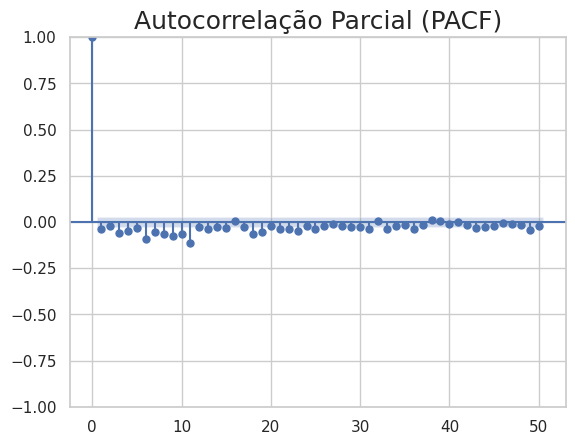

In [113]:
sm.graphics.tsa.plot_pacf(dados_ts_diff, lags=50)

plt.title('Autocorrelação Parcial (PACF)', fontsize=18)

plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAPE: 944.72%


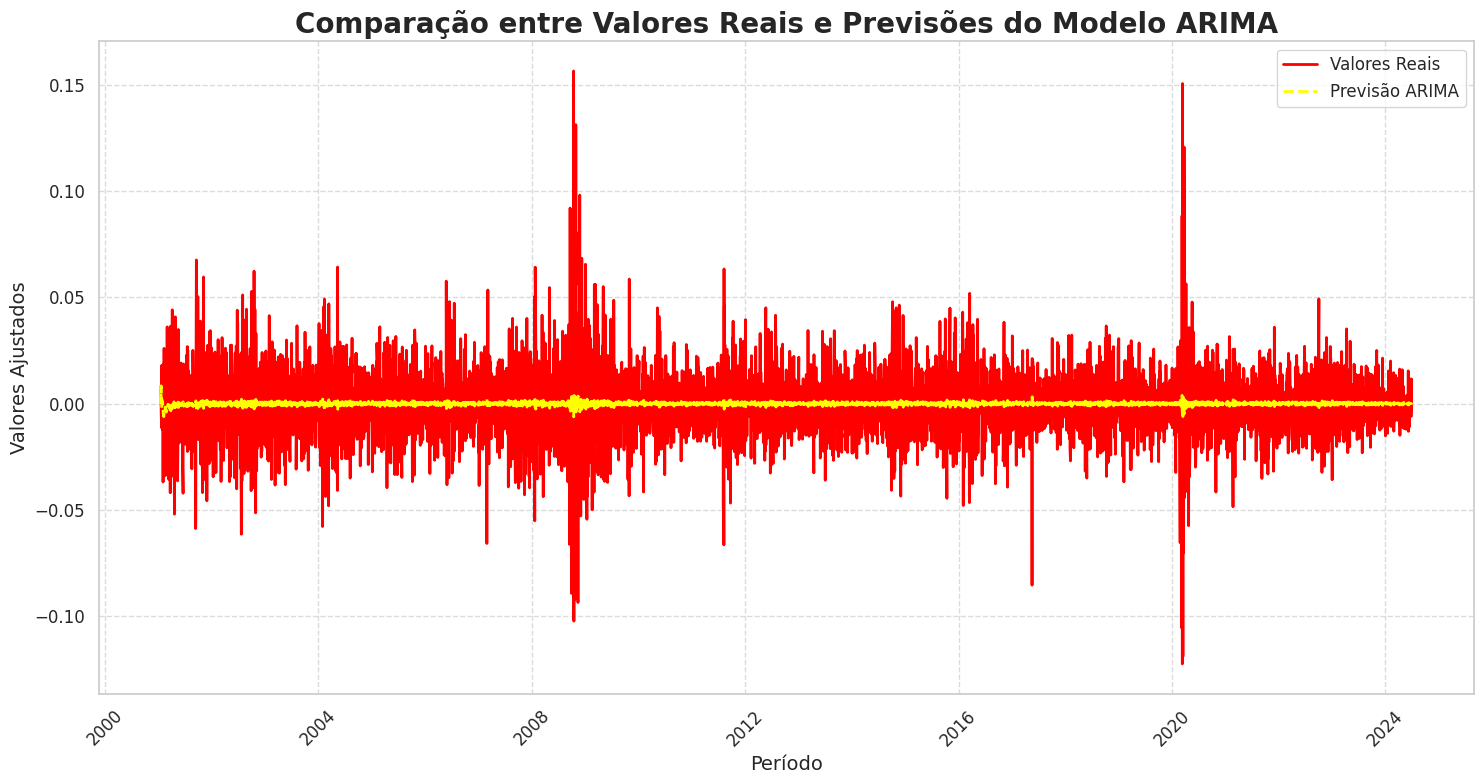

In [121]:
arima = ARIMA(dados_ts_diff, order=(1,1,1))
resultados = arima.fit()
previsao = resultados.predict()

previsao.index = dados_ts_diff.index

valores_previstos = dados_ts_log['Último'].iloc[0] + np.cumsum(previsao)

mape = mean_absolute_error(dados_ts_diff['Último'], valores_previstos) * 100
print(f"MAPE: {mape:.2f}%")

plt.figure(figsize=(15, 8))

plt.plot(dados_ts_diff, color='red', linestyle='-', linewidth=2, label='Valores Reais')
plt.plot(previsao, color='yellow', linestyle='--', linewidth=2, label='Previsão ARIMA')

plt.title('Comparação entre Valores Reais e Previsões do Modelo ARIMA', fontsize=20, fontweight='bold')
plt.xlabel('Período', fontsize=14)
plt.ylabel('Valores Ajustados', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc='best', fontsize=12)

plt.tight_layout()
plt.show()

# De forma randomica.

In [54]:
dados_prophet = dados_ts.reset_index()
dados_prophet[['ds','y']] = dados_prophet[['Data_Corrigida', 'Último']]
dados_prophet.head()

,Data_Corrigida,Último,ds,y
0,2001-01-02,15425.0,2001-01-02,15425.0
1,2001-01-03,16599.0,2001-01-03,16599.0
2,2001-01-04,16675.0,2001-01-04,16675.0
3,2001-01-05,16410.0,2001-01-05,16410.0
4,2001-01-08,16562.0,2001-01-08,16562.0


In [79]:
treino = dados_prophet.sample(frac=0.9, random_state=0)
teste = dados_prophet.drop(treino.index)
print(f'training data size : {treino.shape}')
print(f'testing data size : {teste.shape}')

training data size : (5234, 4)
testing data size : (582, 4)


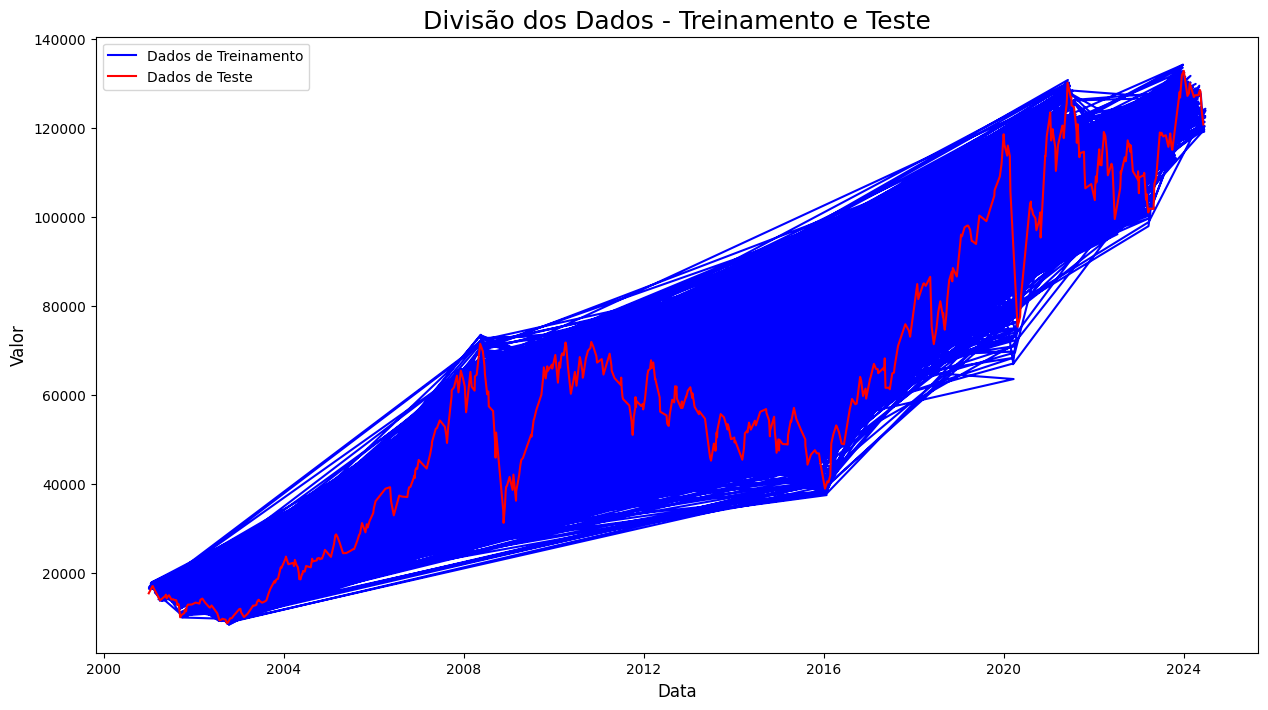

In [59]:
plt.figure(figsize=(15, 8))

plt.plot(treino['ds'], treino['y'], label='Dados de Treinamento', color='blue')

plt.plot(teste['ds'], teste['y'], label='Dados de Teste', color='red')

plt.title('Divisão dos Dados - Treinamento e Teste', fontsize=18)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.legend()
plt.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8u9ksja/ezvk0isx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8u9ksja/s59ky_cr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36243', 'data', 'file=/tmp/tmpu8u9ksja/ezvk0isx.json', 'init=/tmp/tmpu8u9ksja/s59ky_cr.json', 'output', 'file=/tmp/tmpu8u9ksja/prophet_modelrk4o9rko/prophet_model-20240721194315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:43:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:43:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE: 7.28%


<Figure size 1500x800 with 0 Axes>

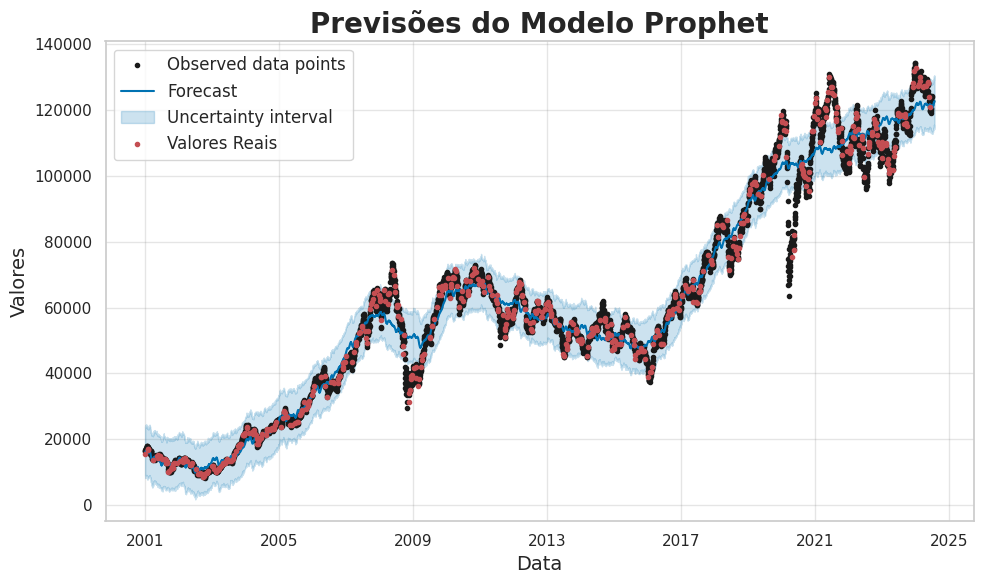

In [122]:
prophet = Prophet(daily_seasonality=True)

prophet.fit(treino)
df_previsao_prophet = prophet.make_future_dataframe(periods=30, freq='D')
previsao_prophet = prophet.predict(df_previsao_prophet)

previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']
previsao = previsao_prophet[previsao_cols]
valores_reais = treino[valores_reais_cols]
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

mape = np.mean(resultados['erro_percentual_absoluto'])
print(f"MAPE: {mape:.2f}%")

plt.figure(figsize=(15,8))
prophet.plot(previsao_prophet)
plt.plot(teste['ds'], teste['y'], 'r.', label='Valores Reais')  # Adicionando a série de valores reais

plt.title('Previsões do Modelo Prophet', fontsize=20, fontweight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Valores', fontsize=14)

plt.legend(loc='best', fontsize=12)

plt.tight_layout()
plt.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8u9ksja/iew5n1rk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8u9ksja/l9wyfpnn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23904', 'data', 'file=/tmp/tmpu8u9ksja/iew5n1rk.json', 'init=/tmp/tmpu8u9ksja/l9wyfpnn.json', 'output', 'file=/tmp/tmpu8u9ksja/prophet_model1mge0sju/prophet_model-20240721194504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:45:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:45:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE: 7.29%


<Figure size 1500x800 with 0 Axes>

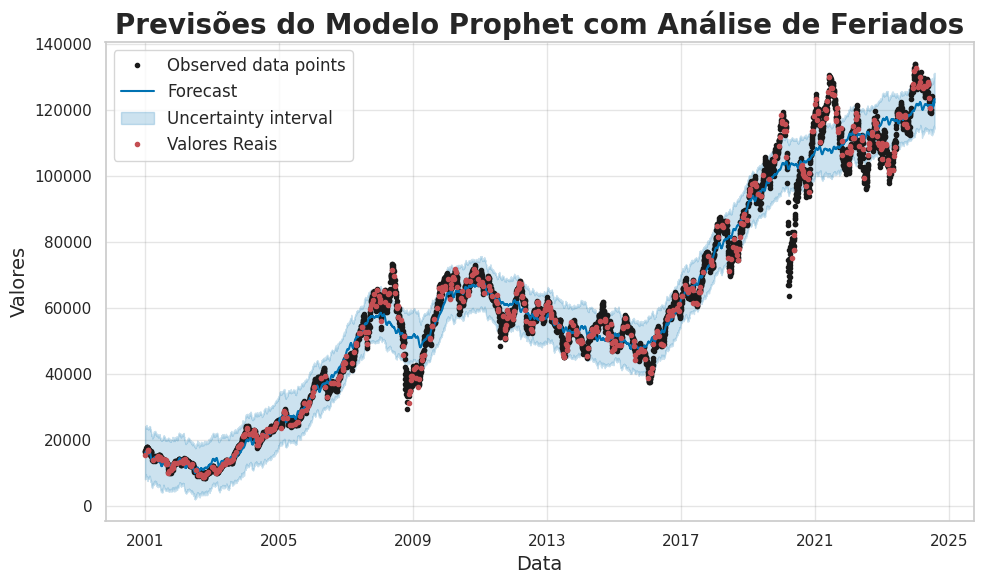

In [123]:
prophet_hol = Prophet(
    seasonality_mode='additive',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True
)

prophet_hol.add_country_holidays(country_name='BR')

prophet_hol.fit(treino)
df_previsao_prophet_hol = prophet_hol.make_future_dataframe(periods=30, freq='D')
previsao_prophet_hol = prophet_hol.predict(df_previsao_prophet_hol)

previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']
previsao_hol = previsao_prophet_hol[previsao_cols]
valores_reais_hol = treino[valores_reais_cols]
resultados_hol = pd.merge(previsao_hol, valores_reais_hol, on='ds', how='inner')

resultados_hol['erro_percentual_absoluto'] = np.abs((resultados_hol['y'] - resultados_hol['yhat']) / resultados_hol['y']) * 100

mape_hol = np.mean(resultados_hol['erro_percentual_absoluto'])
print(f"MAPE: {mape_hol:.2f}%")

plt.figure(figsize=(15,8))
prophet_hol.plot(previsao_prophet_hol)
plt.plot(teste['ds'], teste['y'], 'r.', label='Valores Reais')  # Adicionando a série de valores reais

plt.title('Previsões do Modelo Prophet com Análise de Feriados', fontsize=20, fontweight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Valores', fontsize=14)

plt.legend(loc='best', fontsize=12)

plt.tight_layout()
plt.show()